In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install and import required libraries

In [5]:
!pip install -q datasketch
!pip install -q --upgrade gensim
!cp "/content/drive/MyDrive/multivariante/featurize.py" .

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from featurize import text_featurize

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#/content/drive/MyDrive/multivariante/raw/fakeNews.csv
#/content/drive/MyDrive/multivariante/raw/trueNews.csv

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Read Truthful news

In [7]:
truthful = pd.read_csv("/content/drive/MyDrive/multivariante/raw/trueNews.csv")[["Date Posted", "Text", "Region", "Label"]]
truthful.head()


,Date Posted,Text,Region,Label
0,2/11/20,Just in: Novel coronavirus named 'Covid-19': U...,India,1
1,2/12/20,WHO officially names #coronavirus as Covid-19....,India,1
2,2/12/20,"The #UN #health agency announced that ""COVID-1...",India,1
3,2/14/20,The Indian Embassy in Tokyo has said that one ...,India,1
4,2/15/20,Ground Zero | How Kerala used its experience i...,India,1


## Read Fake News

In [8]:
fake = pd.read_csv("/content/drive/MyDrive/multivariante/raw/fakeNews.csv")[["Date Posted", "Text", "Region", "Binary Label"]].rename(columns={"Binary Label": "Label"})
fake.head()

,Date Posted,Text,Region,Label
0,2/7/20,Tencent revealed the real number of deaths.\t\t,Europe,0
1,2/7/20,Taking chlorine dioxide helps fight coronavir...,Europe,0
2,2/7/20,This video shows workmen uncovering a bat-inf...,India,0
3,2/7/20,The Asterix comic books and The Simpsons pred...,India,0
4,2/7/20,Chinese President Xi Jinping visited a mosque...,India,0


## Concatenate Dataset and transform

In [9]:
dataset = pd.concat((truthful,fake), axis=0)
dataset = dataset.dropna(subset=["Text", "Region", "Label"])
dataset.head()

,Date Posted,Text,Region,Label
0,2/11/20,Just in: Novel coronavirus named 'Covid-19': U...,India,1
1,2/12/20,WHO officially names #coronavirus as Covid-19....,India,1
2,2/12/20,"The #UN #health agency announced that ""COVID-1...",India,1
3,2/14/20,The Indian Embassy in Tokyo has said that one ...,India,1
4,2/15/20,Ground Zero | How Kerala used its experience i...,India,1


Text(0, 0.5, 'training examples')

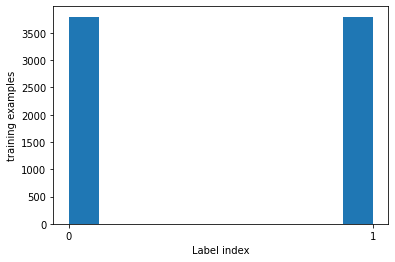

In [10]:
_ = plt.hist(dataset.Label.values)
plt.xticks((0,1))
plt.xlabel("Label index")
plt.ylabel("training examples")

## Extract manual features from text

In [11]:
dataset = text_featurize(dataset, "Text")
dataset.head()

,Date Posted,Text,Region,Label,PCW,PC,L,PP1,RES,SW,OW
0,2/11/20,Just in: Novel coronavirus named 'Covid-19': U...,India,1,0.200000,0.117647,10,0.0,0.0,0.0,0.0
1,2/12/20,WHO officially names #coronavirus as Covid-19....,India,1,0.111111,0.062802,9,0.0,0.0,0.0,0.0
2,2/12/20,"The #UN #health agency announced that ""COVID-1...",India,1,0.100000,0.069930,20,0.0,0.0,0.0,0.0
3,2/14/20,The Indian Embassy in Tokyo has said that one ...,India,1,0.000000,0.032258,22,0.0,0.0,0.0,0.0
4,2/15/20,Ground Zero | How Kerala used its experience i...,India,1,0.038462,0.080214,26,0.0,0.0,0.0,0.0


## Observe the distributions of text length on both truthful and fake ds

Text(0, 0.5, 'Frequency')

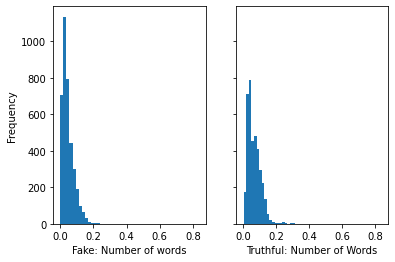

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True)
_ = ax1.hist(dataset[dataset.Label == 0].PC.values, bins=45)
ax1.set_xlabel("Fake: Number of words")
_ = ax2.hist(dataset[dataset.Label==1].PC.values, bins=20)
ax2.set_xlabel("Truthful: Number of Words")
ax1.set_ylabel("Frequency")

## Get documents as tokens, and labels

In [13]:
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import TweetTokenizer
label_encoder = LabelEncoder()
tknzr = TweetTokenizer(reduce_len=True, strip_handles=True)

documents = dataset.Text.values
documents = np.array([tknzr.tokenize(doc) for doc in documents])
text_features = dataset[["PCW", "PC", "L", "RES"]].values
regions = label_encoder.fit_transform(dataset.Region.values)

labels = dataset.Label.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


# Get train/test split indices

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

skf = StratifiedShuffleSplit(n_splits=1)
for train_index, test_index in skf.split(documents, labels):
  print(len(train_index), len(test_index))
  X_train_docs, X_test_docs = documents[train_index], documents[test_index]
  X_train_feats, X_test_feats = text_features[train_index], text_features[test_index]
  X_train_regions, X_test_regions = regions[train_index], regions[test_index]
  
  y_train, y_test = labels[train_index], labels[test_index]

6829 759


## Initialize Doc2Vec Language Model and encode documents

Notice that Doc2Vec only trains on training data

In [15]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents_tweets = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train_docs)]
model_tweets = Doc2Vec(documents_tweets, epochs=50, vector_size=10, window=2, min_count=1, workers=4)
vectors_train = np.array([model_tweets.dv[i] for i in range(len(documents_tweets))], dtype='float32')
vectors_test = np.array([model_tweets.infer_vector(doc) for doc in X_test_docs])

## Concatenate document vectors and manual features


In [16]:
X_train = np.concatenate((vectors_train, X_train_feats, np.reshape(X_train_regions, (-1,1))), axis=-1)
X_test = np.concatenate((vectors_test, X_test_feats, np.reshape(X_test_regions, (-1,1))), axis=-1)

## Correlation matrix

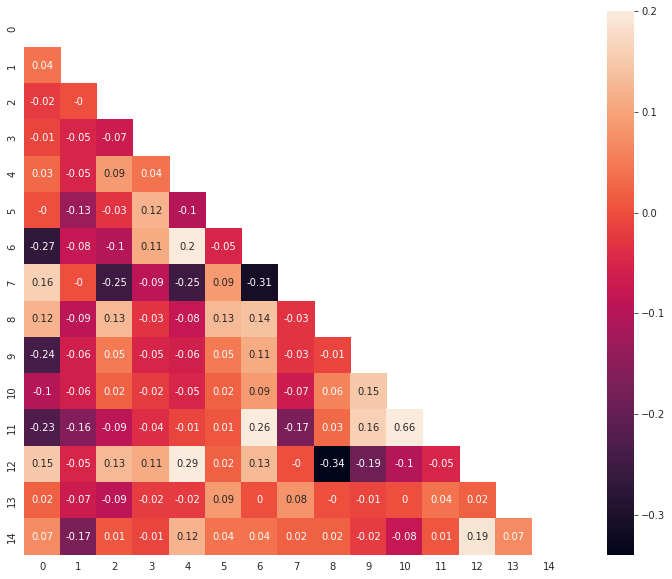

In [17]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [14, 10]
corr = np.corrcoef(X_train.T).round(2)


mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots()
    ax = sns.heatmap(corr, annot=True, mask=mask, vmax=.2, square=True)

## ML classification

In [18]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
from sklearn.metrics import classification_report

y_preds = clf.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       380
           1       0.76      0.87      0.81       379

    accuracy                           0.80       759
   macro avg       0.80      0.80      0.80       759
weighted avg       0.80      0.80      0.80       759



In [20]:
np.savetxt("drive/My Drive/multivariante/features/train_feats.csv", X_train, delimiter=',')
np.savetxt("drive/My Drive/multivariante/features/test_feats.csv", X_test, delimiter=',')